In [2]:
import pandas as pd
import numpy as np
import gzip
import os
import glob
from datetime import datetime
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import re
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [165]:
# Define paths
data_dir = '../data/raw/isd_data'
output_dir = '../data/processed'
os.makedirs(output_dir, exist_ok=True)

# Load station metadata
stations_df = pd.read_csv('../data/processed/selected_stations.csv')
print(f"Loaded metadata for {len(stations_df)} stations")
display(stations_df[['STATION_ID', 'STATION NAME', 'CITY']])

Loaded metadata for 8 stations


,STATION_ID,STATION NAME,CITY
0,744860-94789,JOHN F KENNEDY INTERNATIONAL AIRPORT,New York City
1,722950-23174,LOS ANGELES INTERNATIONAL AIRPORT,Los Angeles
2,725300-94846,CHICAGO O'HARE INTERNATIONAL AIRPORT,Chicago
3,722020-12839,MIAMI INTERNATIONAL AIRPORT,Miami
4,722430-12960,G BUSH INTERCONTINENTAL AP/HOUSTON AP,Houston
5,725090-14739,GEN E L LOGAN INTERNATIONAL AIRPORT,Boston
6,726580-14922,MINNEAPOLIS-ST PAUL INTERNATIONAL AP,Minneapolis
7,727930-24233,SEATTLE-TACOMA INTERNATIONAL AIRPORT,Seattle


In [166]:
# Create a mapping from station ID to city name
station_to_city = dict(zip(stations_df['STATION_ID'], stations_df['CITY']))

In [167]:
# Define the ISD parser
def parse_isd_file(filepath):
    """Parse a NOAA ISD file in the fixed-width format"""
    # List to store parsed records
    records = []
    
    # Station ID from filename
    filename = os.path.basename(filepath)
    station_id = '-'.join(filename.split('-')[:2])  # Extract just the station part
    
    # Get the city for this station
    city = station_to_city.get(station_id, "Unknown")
    
    # Open the gzipped file
    with gzip.open(filepath, 'rt', encoding='utf-8', errors='replace') as f:
        for line in f:
            try:
                # Parse the mandatory fixed section
                record = {
                    'usaf': line[4:10],
                    'wban': line[10:15],
                    'date': line[15:23],  # YYYYMMDD
                    'time': line[23:27],  # HHMM
                    'latitude': line[28:34] if line[28:34].strip() else None,  # Decimal degrees
                    'longitude': line[34:41] if line[34:41].strip() else None,  # Decimal degrees
                    'elevation': line[46:51] if line[46:51].strip() else None,  # Meters
                    'wind_direction': line[60:63] if line[60:63].strip() else None,  # Degrees
                    'wind_speed': line[65:69] if line[65:69].strip() else None,  # Meters/Second * 10
                    'temperature': line[87:92] if line[87:92].strip() else None,  # Celsius * 10
                    'dew_point': line[93:98] if line[93:98].strip() else None,  # Celsius * 10
                    'air_pressure': line[99:104] if line[99:104].strip() else None,  # Hectopascals * 10
                }
                
                # Parse the timestamp
                try:
                    year = int(record['date'][:4])
                    month = int(record['date'][4:6])
                    day = int(record['date'][6:8])
                    hour = int(record['time'][:2])
                    minute = int(record['time'][2:])
                    
                    record['timestamp'] = datetime(year, month, day, hour, minute).isoformat()
                except ValueError:
                    record['timestamp'] = None
                
                # Convert numeric fields and scale appropriately
                for field in ['latitude', 'longitude', 'elevation']:
                    if record[field] is not None and record[field].strip():
                        try:
                            record[field] = float(record[field])
                        except ValueError:
                            record[field] = None
                
                # These fields are scaled by 10 in the data
                for field in ['wind_speed', 'temperature', 'dew_point', 'air_pressure']:
                    if record[field] is not None and record[field].strip():
                        try:
                            record[field] = float(record[field]) / 10.0
                        except ValueError:
                            record[field] = None
                
                # Wind direction is integer degrees
                if record['wind_direction'] is not None and record['wind_direction'].strip():
                    try:
                        record['wind_direction'] = int(record['wind_direction'])
                    except ValueError:
                        record['wind_direction'] = None
                
                # Parse precipitation data which is in variable-length section
                # Look for AA1-AA4 patterns which indicate precipitation data
                record['precipitation'] = None
                record['precipitation_period'] = None
                record['precipitation_condition'] = None
                
                # Search for precipitation markers AA1, AA2, AA3, or AA4
                for marker in ['AA1', 'AA2', 'AA3', 'AA4']:
                    if marker in line:
                        aa_pos = line.find(marker)
                        if aa_pos != -1 and len(line) >= aa_pos + 11:  # Need at least 11 chars after marker
                            # Extract period (hours) - position 3-4 after marker
                            period_str = line[aa_pos+3:aa_pos+5]
                            
                            # Extract depth (mm * 10) - position 5-8 after marker
                            precip_str = line[aa_pos+5:aa_pos+9]
                            
                            # Extract condition code - position 9 after marker
                            condition_str = line[aa_pos+9:aa_pos+10]
                            
                            # Process period
                            if period_str.strip() and period_str != '99':
                                try:
                                    record['precipitation_period'] = int(period_str)
                                except ValueError:
                                    pass
                            
                            # Process depth
                            if precip_str.strip() and precip_str != '9999':
                                try:
                                    # Scale by 10 as per documentation
                                    depth = float(precip_str) / 10.0

                                    # If period is greater than 1 hour, normalize to hourly rate
                                    # This prevents accumulation errors in the monthly sums
                                    if int(period_str) == 1.0:
                                        record['precipitation'] = depth

                                except ValueError:
                                    pass
                            
                            # Process condition
                            if condition_str.strip() and condition_str != '9':
                                record['precipitation_condition'] = condition_str
                                
                                # Handle trace amounts (condition code 2)
                                if condition_str == '2' and record['precipitation'] is None:
                                    # Set trace amounts to a very small value (0.05 mm)
                                    record['precipitation'] = 0.05
                            
                            # If we found valid precipitation data, stop looking
                            if record['precipitation'] is not None:
                                break
                
                # Add city information
                record['city'] = city
                
                # Skip records with missing essential data
                if record['timestamp'] is None or record['temperature'] is None:
                    continue
                    
                records.append(record)
                
            except Exception as e:
                # Skip problematic lines
                continue
    
    # Convert to DataFrame
    if records:
        df = pd.DataFrame(records)
        return df
    else:
        # Return empty DataFrame with correct columns
        return pd.DataFrame(columns=['usaf', 'wban', 'date', 'time', 'latitude', 'longitude', 
                                    'wind_speed', 'temperature', 'timestamp', 
                                    'precipitation', 'precipitation_period', 'precipitation_condition', 'city'])


In [168]:
# Get list of files to process
files = glob.glob(os.path.join(data_dir, '*.gz'))
print(f"Found {len(files)} files to process")

Found 48 files to process


In [169]:
# Process a sample file first to verify parser
if files:
    sample_file = files[0]
    print(f"Processing sample file: {os.path.basename(sample_file)}")
    sample_df = parse_isd_file(sample_file)
    print(f"Sample file contains {len(sample_df)} records")
    if not sample_df.empty:
        display(sample_df.head())
        
        # Check data types and missing values
        print("\nData types:")
        display(sample_df.dtypes)
        
        print("\nMissing values (first 10 columns):")
        display(sample_df.iloc[:, :10].isnull().sum())
    else:
        print("Sample file parsing produced no valid records. Please check the parser.")


Processing sample file: 725300-94846-2020.gz
Sample file contains 12721 records


,usaf,wban,date,time,latitude,longitude,elevation,wind_direction,wind_speed,temperature,dew_point,air_pressure,timestamp,precipitation,precipitation_period,precipitation_condition,city
0,725300,94846,20200101,0000,41983.0,-87900.0,205.0,260,6.2,-2.2,-6.1,1009.8,2020-01-01T00:00:00,NaN,NaN,None,Chicago
1,725300,94846,20200101,0051,41960.0,-87932.0,205.0,260,6.7,-2.2,-6.1,1010.0,2020-01-01T00:51:00,0.0,1.0,None,Chicago
2,725300,94846,20200101,0151,41960.0,-87932.0,205.0,260,6.7,-2.2,-6.1,1010.2,2020-01-01T01:51:00,0.0,1.0,None,Chicago
3,725300,94846,20200101,0205,41960.0,-87932.0,205.0,260,4.6,-2.8,-6.1,9999.9,2020-01-01T02:05:00,NaN,NaN,None,Chicago
4,725300,94846,20200101,0251,41960.0,-87932.0,205.0,250,5.1,-2.8,-6.1,1010.1,2020-01-01T02:51:00,0.0,1.0,None,Chicago



Data types:


usaf                        object
wban                        object
date                        object
time                        object
latitude                   float64
longitude                  float64
elevation                  float64
wind_direction               int64
wind_speed                 float64
temperature                float64
dew_point                  float64
air_pressure               float64
timestamp                   object
precipitation              float64
precipitation_period       float64
precipitation_condition     object
city                        object
dtype: object


Missing values (first 10 columns):


usaf              0
wban              0
date              0
time              0
latitude          0
longitude         0
elevation         0
wind_direction    0
wind_speed        0
temperature       0
dtype: int64

In [183]:
# Ask if we should proceed with all files
proceed = input("Proceed with processing all files? (y/n): ")

if proceed.lower() != 'y':
    print("Processing stopped.")
else:
    # Process all files with progress bar
    all_data = []
    successful_files = 0
    empty_files = 0
    error_files = 0
    
    for filepath in tqdm(files, desc="Processing files"):
        try:
            df = parse_isd_file(filepath)
            if not df.empty:
                all_data.append(df)
                successful_files += 1
            else:
                empty_files += 1
                print(f"Warning: No valid records in {os.path.basename(filepath)}")
        except Exception as e:
            error_files += 1
            print(f"Error processing {os.path.basename(filepath)}: {str(e)}")
    
    print(f"\nProcessing summary:")
    print(f"- Successfully processed: {successful_files} files")
    print(f"- Empty files (no valid records): {empty_files} files")
    print(f"- Processing errors: {error_files} files")

    # Combine all data
    if all_data:
        combined_df = pd.concat(all_data, ignore_index=True)
        print(f"Combined data has {combined_df.shape[0]} rows and {combined_df.shape[1]} columns")
        
        # Drop any duplicates
        combined_df = combined_df.drop_duplicates(subset=['usaf', 'wban', 'timestamp'])
        print(f"After removing duplicates: {combined_df.shape[0]} rows")
        
        # Clean the data
        # Remove any remaining rows with missing essential data
        combined_df = combined_df.dropna(subset=['timestamp', 'temperature', 'city'])
        print(f"After removing rows with missing data: {combined_df.shape[0]} rows")
        
        # Convert timestamp to datetime for easier filtering and analysis
        combined_df['datetime'] = pd.to_datetime(combined_df['timestamp'])
        
        # Add date and hour columns
        combined_df['date'] = combined_df['datetime'].dt.date
        combined_df['hour'] = combined_df['datetime'].dt.hour
        
        # Sort by city and timestamp
        combined_df = combined_df.sort_values(['city', 'datetime'])
        
        # Save to CSV
        output_path = os.path.join(output_dir, 'hourly_weather_data.csv')
        combined_df.to_csv(output_path, index=False)
        print(f"Saved processed data to {output_path}")

Processing files:   0%|          | 0/48 [00:00<?, ?it/s]


Processing summary:
- Successfully processed: 48 files
- Empty files (no valid records): 0 files
- Processing errors: 0 files
Combined data has 727144 rows and 17 columns
After removing duplicates: 723209 rows
After removing rows with missing data: 723209 rows
Saved processed data to ../data/processed/hourly_weather_data.csv


In [ ]:
# # Filter out precipitation data with period greater than 1 hour
# precip_period_1 = combined_df['precipitation_period'] == 1.0
# combined_df = combined_df[precip_period_1]

In [184]:
# 1. Remove unnecessary columns
columns_to_remove = ['elevation', 'wind_direction', 'dew_point', 'air_pressure', 'time', 'precipitation_condition']
print(f"\nRemoving columns: {columns_to_remove}")
for col in columns_to_remove:
    if col in combined_df.columns:
        combined_df = combined_df.drop(columns=col)
    else:
        print(f"Column '{col}' not found in dataframe")

print(f"After removing columns: {combined_df.shape[1]} columns remain")


Removing columns: ['elevation', 'wind_direction', 'dew_point', 'air_pressure', 'time', 'precipitation_condition']
After removing columns: 13 columns remain


In [185]:
# 2. Remove invalid data points (extreme values that likely represent missing/error codes)
print("\nChecking for extreme values:")
# Count before filtering
total_rows_before = len(combined_df)

# Check wind speed values
if 'wind_speed' in combined_df.columns:
    invalid_wind = combined_df['wind_speed'] > 900
    print(f"Found {invalid_wind.sum()} rows with wind_speed > 900")
else:
    invalid_wind = pd.Series([False] * len(combined_df))
    print("Column 'wind_speed' not found")

# Check temperature values
if 'temperature' in combined_df.columns:
    invalid_temp = combined_df['temperature'] > 900
    print(f"Found {invalid_temp.sum()} rows with temperature > 900")
else:
    invalid_temp = pd.Series([False] * len(combined_df))
    print("Column 'temperature' not found")


Checking for extreme values:
Found 108849 rows with wind_speed > 900
Found 108673 rows with temperature > 900


In [186]:
# Combined filter for any invalid values
invalid_rows = invalid_wind | invalid_temp
combined_df = combined_df[~invalid_rows]

# Count after filtering
total_rows_after = len(combined_df)
print(f"Removed {total_rows_before - total_rows_after} rows with invalid values")
print(f"Remaining rows: {total_rows_after}")

Removed 108890 rows with invalid values
Remaining rows: 614319


In [187]:
# Display value ranges after cleaning
print("\nValue ranges after cleaning:")
for column in ['temperature', 'wind_speed', 'precipitation']:
    if column in combined_df.columns:
        min_val = combined_df[column].min()
        max_val = combined_df[column].max()
        print(f"{column}: min={min_val}, max={max_val}")


Value ranges after cleaning:
temperature: min=-33.3, max=42.8
wind_speed: min=0.0, max=26.3
precipitation: min=0.0, max=98.0


In [188]:
combined_df.sort_values(by='precipitation', ascending=False).head(10)

,usaf,wban,date,latitude,longitude,wind_speed,temperature,timestamp,precipitation,precipitation_period,city,datetime,hour
21483,722430,12960,2019-09-19,29980.0,-95360.0,8.2,24.0,2019-09-19T14:53:00,98.0,1.0,Houston,2019-09-19 14:53:00,14
388948,722020,12839,2020-05-26,25788.0,-80317.0,4.6,22.0,2020-05-26T22:53:00,84.6,1.0,Miami,2020-05-26 22:53:00,22
388947,722020,12839,2020-05-26,25788.0,-80317.0,4.1,22.0,2020-05-26T22:47:00,81.7,1.0,Miami,2020-05-26 22:47:00,22
388944,722020,12839,2020-05-26,25788.0,-80317.0,7.7,22.0,2020-05-26T21:53:00,78.5,1.0,Miami,2020-05-26 21:53:00,21
21487,722430,12960,2019-09-19,29980.0,-95360.0,5.7,24.0,2019-09-19T15:44:00,72.1,1.0,Houston,2019-09-19 15:44:00,15
388946,722020,12839,2020-05-26,25788.0,-80317.0,3.1,22.0,2020-05-26T22:35:00,71.6,1.0,Miami,2020-05-26 22:35:00,22
21488,722430,12960,2019-09-19,29980.0,-95360.0,3.1,24.0,2019-09-19T15:53:00,68.3,1.0,Houston,2019-09-19 15:53:00,15
416030,722430,12960,2024-06-11,29984.0,-95361.0,3.1,22.8,2024-06-11T01:35:00,64.7,1.0,Houston,2024-06-11 01:35:00,1
416067,722430,12960,2024-06-11,29984.0,-95361.0,8.2,23.9,2024-06-11T23:53:00,64.5,1.0,Houston,2024-06-11 23:53:00,23
416031,722430,12960,2024-06-11,29984.0,-95361.0,2.6,23.3,2024-06-11T01:53:00,62.7,1.0,Houston,2024-06-11 01:53:00,1



Examining precipitation data...
Missing precipitation values: 158208 (25.8% of records)

Precipitation value distribution:
(-0.099, 9.8]: 73.97%
(9.8, 19.6]: 0.20%
(19.6, 29.4]: 0.05%
(29.4, 39.2]: 0.02%
(39.2, 49.0]: 0.01%
(49.0, 58.8]: 0.00%
(58.8, 68.6]: 0.00%
(68.6, 78.4]: 0.00%
(78.4, 88.2]: 0.00%
(88.2, 98.0]: 0.00%

Average precipitation by city:


,avg_mm,max_mm,min_mm,pct_with_rain
city,,,,
Boston,0.196568,35.8,0.0,10.371763
Chicago,0.198988,49.5,0.0,10.094975
Houston,0.254023,98.0,0.0,6.416955
Los Angeles,0.072651,19.6,0.0,3.144783
Miami,0.455988,84.6,0.0,8.363937
Minneapolis,0.177979,40.4,0.0,9.887480
New York City,0.180292,37.8,0.0,8.448743
Seattle,0.146701,11.9,0.0,12.028402


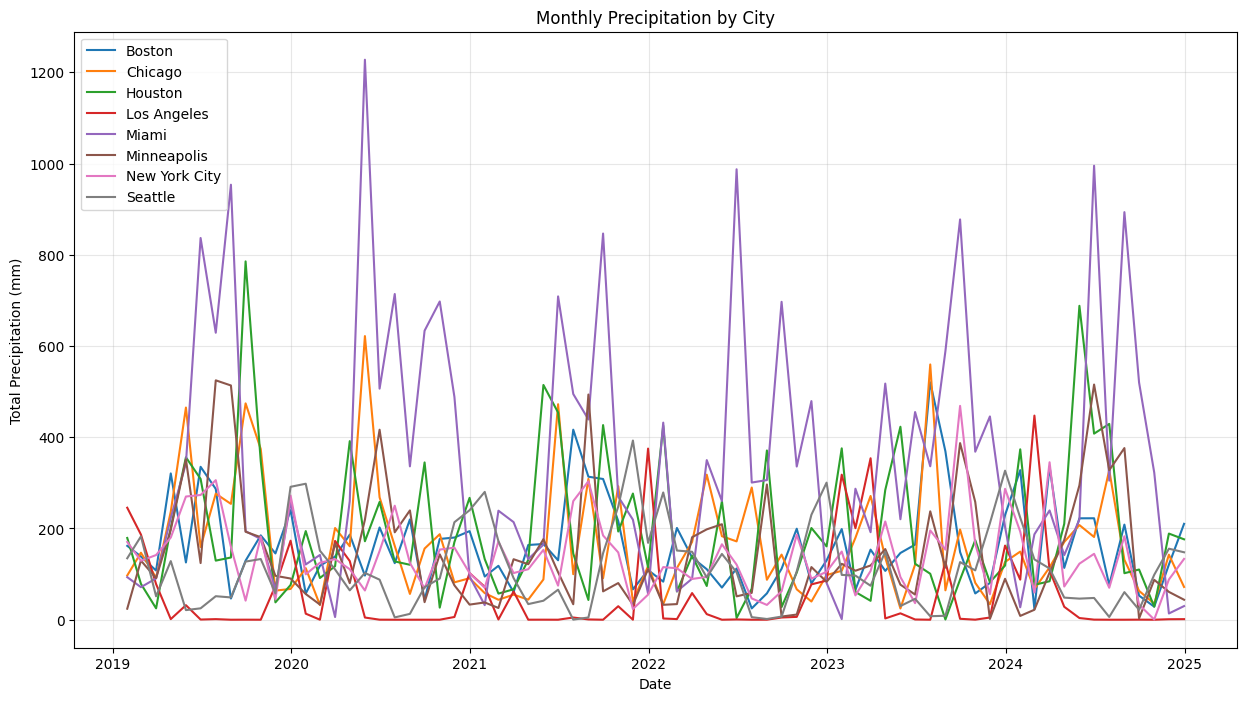

In [189]:
# Check precipitation data after processing all files
print("\nExamining precipitation data...")

# Count missing precipitation values
missing_precip = combined_df['precipitation'].isna().sum()
total_rows = len(combined_df)
print(f"Missing precipitation values: {missing_precip} ({missing_precip/total_rows*100:.1f}% of records)")

# Value distribution
print("\nPrecipitation value distribution:")
precip_counts = combined_df['precipitation'].value_counts(bins=10, normalize=True).sort_index()
for bin_range, count in precip_counts.items():
    print(f"{bin_range}: {count*100:.2f}%")

# Check for anomalous values
anomalous_high = combined_df[combined_df['precipitation'] > 100]
if len(anomalous_high) > 0:
    print(f"\nFound {len(anomalous_high)} records with extremely high precipitation (>100mm)")
    print("Sample of high precipitation records:")
    display(anomalous_high.head())

# Check precipitation condition codes if available
if 'precipitation_condition' in combined_df.columns:
    print("\nPrecipitation condition code distribution:")
    condition_counts = combined_df['precipitation_condition'].value_counts()
    for code, count in condition_counts.items():
        code_desc = {
            '1': 'Measurement impossible or inaccurate',
            '2': 'Trace',
            '3': 'Begin accumulated period',
            '4': 'End accumulated period',
            '5': 'Begin deleted period',
            '6': 'End deleted period',
            '7': 'Begin missing period',
            '8': 'End missing period',
            'E': 'Estimated data value',
            'I': 'Incomplete (missing reports)',
            'J': 'Incomplete (erroneous reports)',
            '9': 'Missing'
        }.get(code, 'Unknown')
        
        print(f"{code} ({code_desc}): {count} records")

# Precipitation by city
print("\nAverage precipitation by city:")
city_precip = combined_df.groupby('city')['precipitation'].agg(['mean', 'max', 'min', lambda x: (x > 0).mean() * 100])
city_precip.columns = ['avg_mm', 'max_mm', 'min_mm', 'pct_with_rain']
display(city_precip)

# Precipitation over time (monthly)
monthly_precip = combined_df.set_index('datetime').groupby([pd.Grouper(freq='M'), 'city'])['precipitation'].sum().reset_index()

plt.figure(figsize=(15, 8))
for city in combined_df['city'].unique():
    city_data = monthly_precip[monthly_precip['city'] == city]
    plt.plot(city_data['datetime'], city_data['precipitation'], label=city)

plt.title('Monthly Precipitation by City')
plt.xlabel('Date')
plt.ylabel('Total Precipitation (mm)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.savefig(os.path.join(output_dir, 'monthly_precipitation.png'))
plt.show()

In [190]:
# Handle duplicate entries and missing hours

# First, ensure datetime is proper datetime type
combined_df['datetime'] = pd.to_datetime(combined_df['datetime'])

# Group by city, date, and hour to remove duplicates
print("\nHandling duplicate hour entries...")
before_dedup = len(combined_df)

# Define columns to average
numeric_cols = ['temperature', 'wind_speed', 'precipitation']

# Identify the grouping columns
groupby_cols = ['city', 'date', 'hour']

# Define a custom aggregation function for precipitation
def agg_precipitation(series):
    # Get corresponding precipitation_period values
    periods = combined_df.loc[series.index, 'precipitation_period']
    
    # Filter for hourly values (period == 1.0)
    hourly_series = series[periods == 1.0]
    
    if len(hourly_series) > 0:
        # If we have hourly values, take their mean
        return hourly_series.mean()
    else:
        # If no hourly values, take mean of all values
        return series.mean() if len(series) > 0 else None

# Group and aggregate
grouped_df = combined_df.groupby(groupby_cols).agg({
    'city': 'first',
    'usaf': 'first',
    'wban': 'first',
    'date': 'first',
    'hour': 'first',
    # Average the numeric columns
    'temperature': 'mean',
    'wind_speed': 'mean', 
    'precipitation': agg_precipitation,
    # Keep the first value for other columns
    'datetime': 'first',
    'latitude': 'first',
    'longitude': 'first'
}).reset_index(drop=True)

# Round numeric columns to two decimal places
grouped_df['temperature'] = grouped_df['temperature'].round(2)
grouped_df['wind_speed'] = grouped_df['wind_speed'].round(2)
grouped_df['precipitation'] = grouped_df['precipitation'].round(2)

print(f"Removed {before_dedup - len(grouped_df)} duplicate hour entries")
print(f"After removing duplicates: {len(grouped_df)} rows")


Handling duplicate hour entries...
Removed 193658 duplicate hour entries
After removing duplicates: 420661 rows


In [191]:
# Check for missing hours
print("\nChecking for missing hours...")

# Create a new column with just the date and hour
grouped_df['date_hour'] = grouped_df['datetime'].dt.floor('H')

# Get the complete date range
start_date = grouped_df['date_hour'].min()
end_date = grouped_df['date_hour'].max()

# Get list of all cities
cities = grouped_df['city'].unique()
print(f"Found {len(cities)} cities")
print(f"Date range: {start_date} to {end_date}")

# For each city, check for missing hours
for city in cities:
    # Get data for this city
    city_data = grouped_df[grouped_df['city'] == city]
    
    # Create a complete set of hours that should exist
    expected_hours = pd.date_range(start=start_date, end=end_date, freq='H')
    
    # Get the actual hours in the data
    actual_hours = city_data['date_hour'].unique()
    
    # Find missing hours
    missing_hours = set(expected_hours) - set(actual_hours)
    
    if missing_hours:
        print(f"\n{city} is missing {len(missing_hours)} hours out of {len(expected_hours)} ({len(missing_hours)/len(expected_hours)*100:.2f}%)")
        
        # Show some examples of missing hours
        missing_hours_list = sorted(list(missing_hours))
        if len(missing_hours_list) > 0:
            print("Examples of missing hours:")
            for hour in missing_hours_list[:5]:  # Show first 5 missing hours
                print(f"  {hour}")
            
            # Look for patterns in missing data
            # Check for consecutive missing days
            missing_days = [h.date() for h in missing_hours_list]
            missing_days = sorted(set(missing_days))
            consecutive_days = []
            current_streak = []
            
            for i, day in enumerate(missing_days):
                if i == 0 or (day - missing_days[i-1]).days == 1:
                    current_streak.append(day)
                else:
                    if len(current_streak) > 0:
                        consecutive_days.append(current_streak)
                    current_streak = [day]
            
            if current_streak:
                consecutive_days.append(current_streak)
            
            # Report on consecutive missing days
            long_streaks = [streak for streak in consecutive_days if len(streak) > 7]
            if long_streaks:
                print("\n  Notable gaps (>7 consecutive days):")
                for streak in long_streaks:
                    print(f"    {streak[0]} to {streak[-1]} ({len(streak)} days)")
    else:
        print(f"\n{city} has complete hourly data for the entire period")

# Overall summary
print("\nOverall data completeness:")
total_expected = len(expected_hours) * len(cities)
total_actual = len(grouped_df)
missing_percentage = (total_expected - total_actual) / total_expected * 100
print(f"Total expected entries: {total_expected}")
print(f"Actual entries: {total_actual}")
print(f"Missing percentage: {missing_percentage:.2f}%")


Checking for missing hours...
Found 8 cities
Date range: 2019-01-01 00:00:00 to 2024-12-31 23:00:00

Boston is missing 7 hours out of 52608 (0.01%)
Examples of missing hours:
  2019-10-30 07:00:00
  2019-10-30 08:00:00
  2024-05-01 04:00:00
  2024-08-20 00:00:00
  2024-10-31 04:00:00

Chicago is missing 19 hours out of 52608 (0.04%)
Examples of missing hours:
  2019-03-01 16:00:00
  2021-05-08 15:00:00
  2024-09-15 17:00:00
  2024-12-01 06:00:00
  2024-12-01 07:00:00

Houston has complete hourly data for the entire period

Los Angeles is missing 21 hours out of 52608 (0.04%)
Examples of missing hours:
  2019-07-03 16:00:00
  2020-05-09 14:00:00
  2021-03-22 07:00:00
  2021-06-05 15:00:00
  2022-12-03 23:00:00

Miami is missing 34 hours out of 52608 (0.06%)
Examples of missing hours:
  2019-02-07 11:00:00
  2019-04-21 14:00:00
  2019-05-07 11:00:00
  2019-10-26 01:00:00
  2020-03-30 17:00:00

Minneapolis is missing 35 hours out of 52608 (0.07%)
Examples of missing hours:
  2020-04-17 2

In [192]:
combined_df = grouped_df.copy()
# Save to CSV
output_path = os.path.join(output_dir, 'hourly_weather_data_cleaned.csv')
combined_df.to_csv(output_path, index=False)

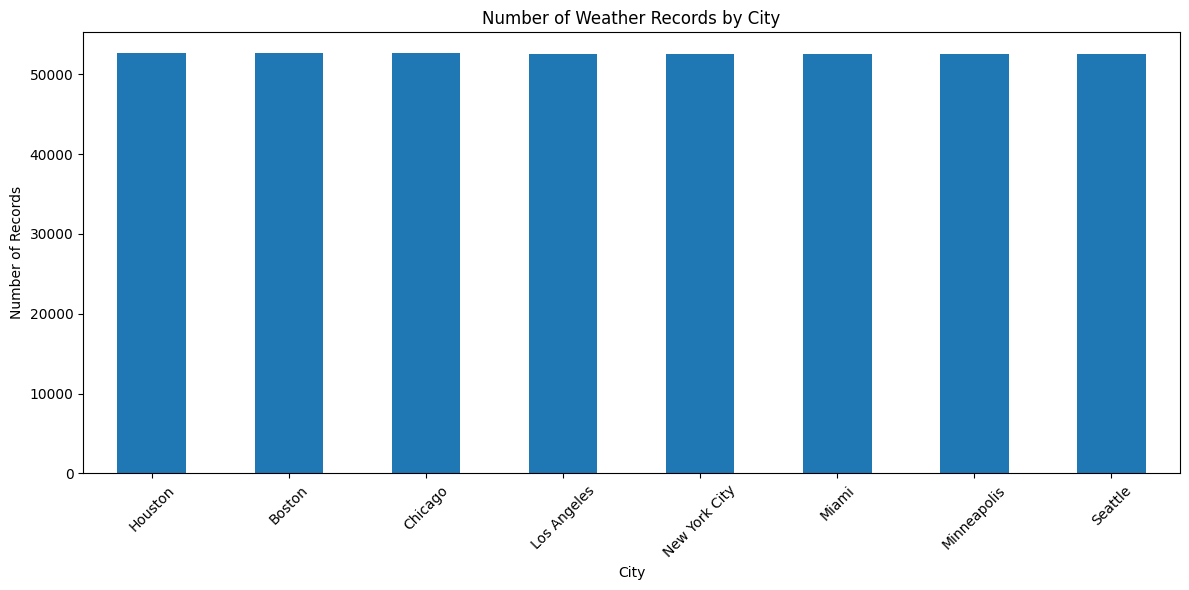

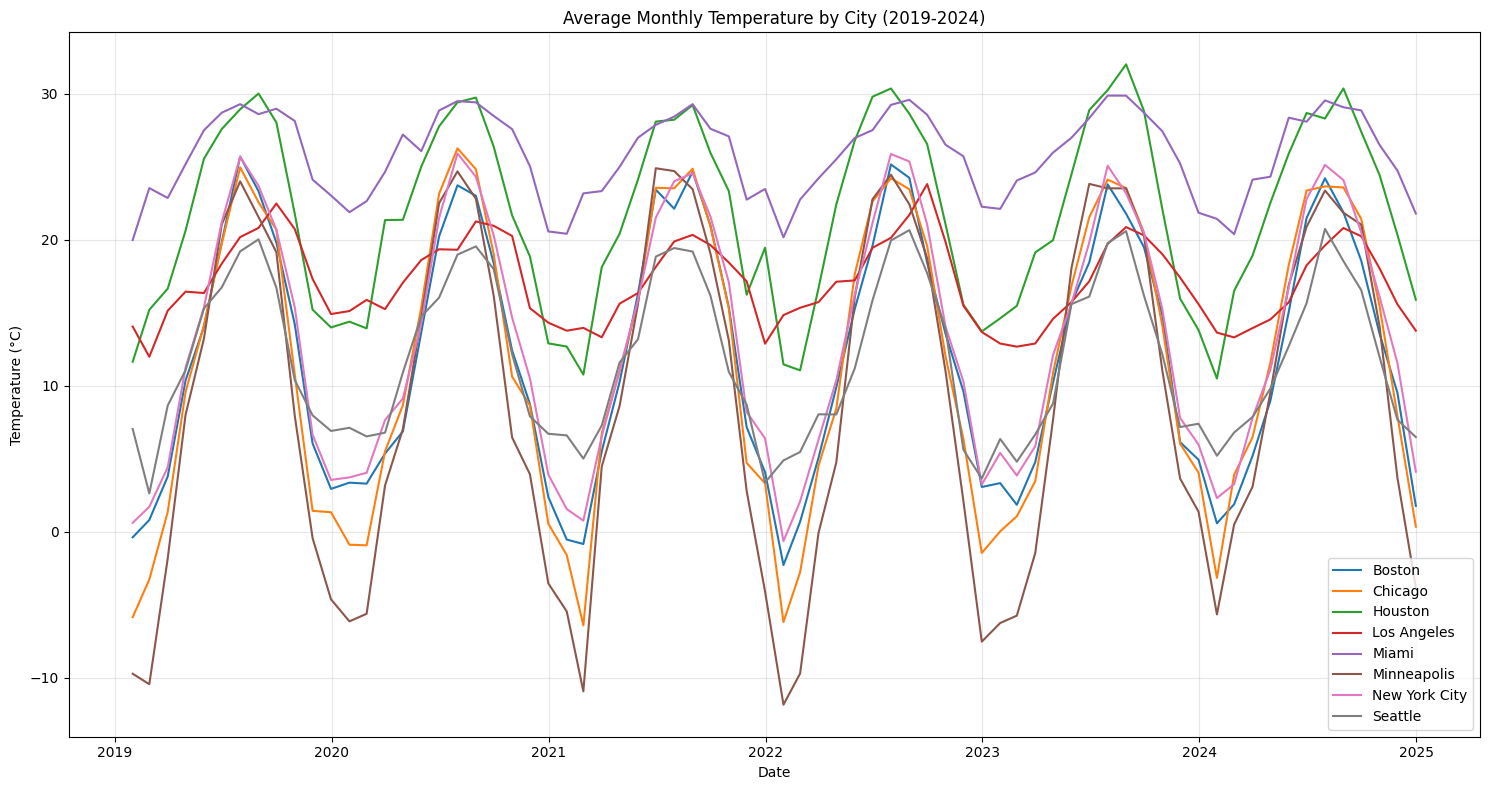

Saved summary statistics to ../data/processed/weather_summary_by_city.csv


,avg_temp_c,min_temp_c,max_temp_c,temp_std_c,avg_precip_mm,total_precip_mm,pct_days_with_rain,avg_wind_speed_m_s,max_wind_speed_m_s
city,,,,,,,,,
Boston,12.015859,-22.9,37.20,9.485360,0.100176,5240.13,8.155738,4.830389,20.55
Chicago,11.563381,-30.6,37.80,11.192159,0.082180,4233.24,6.841735,4.260672,16.50
Houston,21.773945,-10.6,42.80,8.071875,0.105905,5541.69,4.649483,3.463838,23.70
Los Angeles,17.131942,4.4,38.30,4.048565,0.035264,1826.34,2.247704,3.284985,18.50
Miami,25.837677,4.4,36.70,4.097170,0.163625,8459.76,6.016282,3.466619,14.90
Minneapolis,9.095479,-33.3,38.30,12.882847,0.067916,3504.87,6.159055,4.067661,15.43
New York City,13.263762,-16.1,36.70,9.103410,0.111306,5740.94,7.494248,5.063584,21.65
Seattle,11.781120,-9.4,41.15,6.634833,0.099492,5057.47,11.004530,3.489878,16.45



Data range: 2019-01-01 to 2024-12-31 (2192 days)

Data completeness by city:
Boston: 2192/2192 days (100.0%)
Chicago: 2192/2192 days (100.0%)
Houston: 2192/2192 days (100.0%)
Los Angeles: 2192/2192 days (100.0%)
Miami: 2192/2192 days (100.0%)
Minneapolis: 2192/2192 days (100.0%)
New York City: 2192/2192 days (100.0%)
Seattle: 2192/2192 days (100.0%)


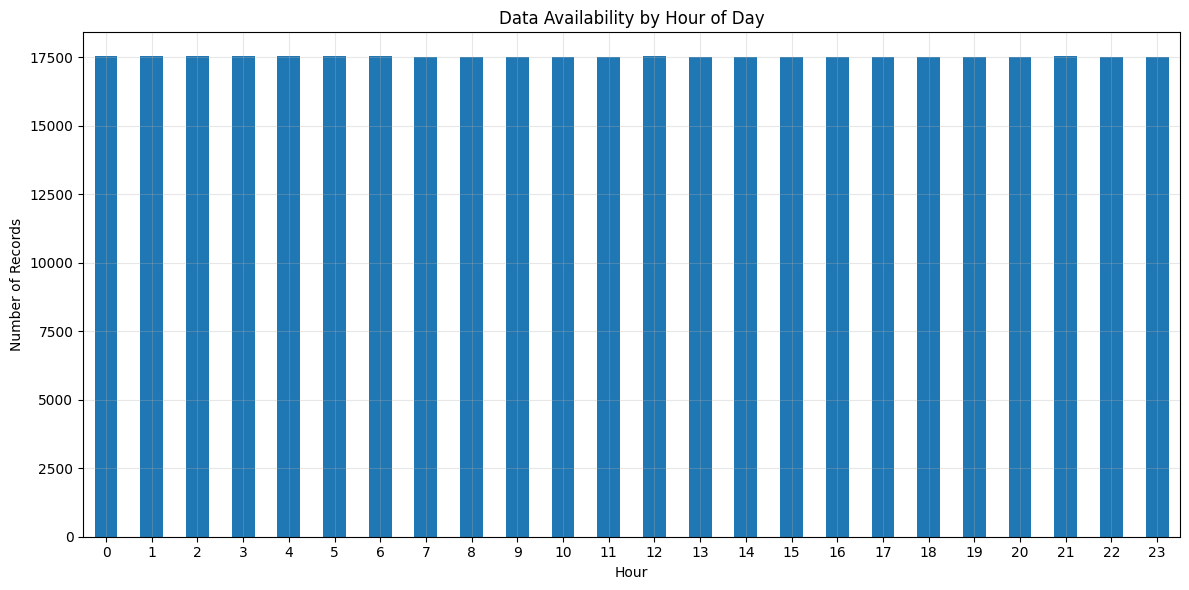

In [193]:
# Basic visualization
# 1. Data availability by city
city_counts = combined_df['city'].value_counts()

plt.figure(figsize=(12, 6))
city_counts.plot(kind='bar')
plt.title('Number of Weather Records by City')
plt.xlabel('City')
plt.ylabel('Number of Records')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig(os.path.join(output_dir, 'records_by_city.png'))
plt.show()

# 2. Temperature trends
plt.figure(figsize=(15, 8))

# Group by city and date, get average temperature
temp_by_city_date = combined_df.groupby(['city', pd.Grouper(key='datetime', freq='M')])['temperature'].mean().reset_index()

# Plot for each city
for city in combined_df['city'].unique():
    city_data = temp_by_city_date[temp_by_city_date['city'] == city]
    plt.plot(city_data['datetime'], city_data['temperature'], label=city)

plt.title('Average Monthly Temperature by City (2019-2024)')
plt.xlabel('Date')
plt.ylabel('Temperature (°C)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(os.path.join(output_dir, 'temperature_trends.png'))
plt.show()

# 3. Summary statistics
summary_stats = combined_df.groupby('city').agg({
    'temperature': ['mean', 'min', 'max', 'std'],
    'precipitation': ['mean', 'sum', lambda x: (x > 0).mean() * 100],  # % of days with precipitation
    'wind_speed': ['mean', 'max']
})

# Rename columns for clarity
summary_stats.columns = ['_'.join(col).strip() for col in summary_stats.columns.values]
summary_stats = summary_stats.rename(columns={
    'temperature_mean': 'avg_temp_c',
    'temperature_min': 'min_temp_c',
    'temperature_max': 'max_temp_c',
    'temperature_std': 'temp_std_c',
    'precipitation_mean': 'avg_precip_mm',
    'precipitation_sum': 'total_precip_mm',
    'precipitation_<lambda_0>': 'pct_days_with_rain',
    'wind_speed_mean': 'avg_wind_speed_m_s',
    'wind_speed_max': 'max_wind_speed_m_s'
})

# Save summary stats
summary_stats.to_csv(os.path.join(output_dir, 'weather_summary_by_city.csv'))
print(f"Saved summary statistics to {os.path.join(output_dir, 'weather_summary_by_city.csv')}")

# Display summary stats
display(summary_stats)

# 4. Data completeness check (days with data by city)
# Get the date range in the data
start_date = combined_df['datetime'].min().date()
end_date = combined_df['datetime'].max().date()
date_range = pd.date_range(start=start_date, end=end_date).date

print(f"\nData range: {start_date} to {end_date} ({len(date_range)} days)")

# Check days with data for each city
print("\nData completeness by city:")
for city in combined_df['city'].unique():
    city_data = combined_df[combined_df['city'] == city]
    city_dates = city_data['date'].unique()
    coverage = (len(city_dates) / len(date_range)) * 100
    print(f"{city}: {len(city_dates)}/{len(date_range)} days ({coverage:.1f}%)")

# 5. Hourly data patterns
plt.figure(figsize=(12, 6))
hourly_counts = combined_df['hour'].value_counts().sort_index()
hourly_counts.plot(kind='bar')
plt.title('Data Availability by Hour of Day')
plt.xlabel('Hour')
plt.ylabel('Number of Records')
plt.xticks(rotation=0)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(os.path.join(output_dir, 'records_by_hour.png'))
plt.show()


In [196]:
def impute_missing_hours(combined_df):
    # Create a complete date-hour index for the entire period
    start_date = '2019-01-01 00:00:00'
    end_date = '2024-12-31 23:00:00'
    complete_index = pd.date_range(start=start_date, end=end_date, freq='H')
    
    # Convert date and hour columns to datetime if they aren't already
    if not pd.api.types.is_datetime64_any_dtype(combined_df['date']):
        combined_df['datetime'] = pd.to_datetime(combined_df['date']) + pd.to_timedelta(combined_df['hour'], unit='h')
    else:
        combined_df['datetime'] = combined_df['date'] + pd.to_timedelta(combined_df['hour'], unit='h')
    
    # Get list of all cities in the dataset
    cities = combined_df['city'].unique() if 'city' in combined_df.columns else ['unknown']
    
    # Create a dictionary to store imputed dataframes for each city
    imputed_dfs = {}
    
    for city in cities:
        # Filter data for the current city
        if 'city' in combined_df.columns:
            city_df = combined_df[combined_df['city'] == city].copy()
        else:
            city_df = combined_df.copy()
        
        # Set the datetime as index
        city_df = city_df.set_index('datetime')
        
        # Reindex to include all hours in the complete index
        complete_city_df = city_df.reindex(complete_index)
        
        # Identify missing hours
        missing_indicator = complete_city_df['temperature'].isna() if 'temperature' in complete_city_df.columns else complete_city_df.index.isin(complete_index.difference(city_df.index))
        missing_hours = complete_city_df[missing_indicator].index
        print(f"{city} is missing {len(missing_hours)} hours out of {len(complete_index)} ({len(missing_hours)/len(complete_index)*100:.2f}%)")
        
        if len(missing_hours) > 0:
            print("Examples of missing hours:")
            for hour in missing_hours[:5]:
                print(f"  {hour}")
        
        # 1. Fill forward values for columns that should use previous row values
        forward_fill_columns = ['city', 'usaf', 'wban', 'date', 'latitude', 'longitude']
        for col in forward_fill_columns:
            if col in complete_city_df.columns:
                complete_city_df[col] = complete_city_df[col].ffill().bfill()  # bfill handles edge case if first values are missing
        
        # 2. For hour column, fill with the actual hour from the datetime index
        if 'hour' in complete_city_df.columns:
            complete_city_df['hour'] = complete_city_df.index.hour
        
        # 3. For numeric measurement columns, take average of before and after
        numeric_columns = ['temperature', 'wind_speed', 'precipitation']
        # First create copies with forward and backward fill
        ffill_df = complete_city_df[numeric_columns].ffill() if all(col in complete_city_df.columns for col in numeric_columns) else None
        bfill_df = complete_city_df[numeric_columns].bfill() if all(col in complete_city_df.columns for col in numeric_columns) else None
        
        if ffill_df is not None and bfill_df is not None:
            for col in numeric_columns:
                if col in complete_city_df.columns:
                    # Where values are missing in the original dataframe
                    mask = complete_city_df[col].isna()
                    # Take the average of ffill and bfill values
                    complete_city_df.loc[mask, col] = (ffill_df.loc[mask, col] + bfill_df.loc[mask, col]) / 2
        
        # Reset index to get datetime back as a column
        complete_city_df = complete_city_df.reset_index()
        
        # Handle date column if it needs to be extracted from the datetime
        if 'date' not in complete_city_df.columns:
            complete_city_df['date'] = complete_city_df['index'].dt.date
        
        # Rename index column to datetime if needed
        if 'datetime' not in complete_city_df.columns:
            complete_city_df = complete_city_df.rename(columns={'index': 'datetime'})
            
        imputed_dfs[city] = complete_city_df
    
    # Combine all city dataframes
    if len(cities) > 1:
        imputed_combined_df = pd.concat(imputed_dfs.values())
    else:
        imputed_combined_df = list(imputed_dfs.values())[0]
    
    return imputed_combined_df

In [198]:
imputed_df = impute_missing_hours(combined_df)
imputed_df.drop(columns=['date_hour'], inplace=True)

output_path = os.path.join(output_dir, 'hourly_weather_data_imputed.csv')
imputed_df.to_csv(output_path, index=False)

Boston is missing 7 hours out of 52608 (0.01%)
Examples of missing hours:
  2019-10-30 07:00:00
  2019-10-30 08:00:00
  2024-05-01 04:00:00
  2024-08-20 00:00:00
  2024-10-31 04:00:00
Chicago is missing 19 hours out of 52608 (0.04%)
Examples of missing hours:
  2019-03-01 16:00:00
  2021-05-08 15:00:00
  2024-09-15 17:00:00
  2024-12-01 06:00:00
  2024-12-01 07:00:00
Houston is missing 0 hours out of 52608 (0.00%)
Los Angeles is missing 21 hours out of 52608 (0.04%)
Examples of missing hours:
  2019-07-03 16:00:00
  2020-05-09 14:00:00
  2021-03-22 07:00:00
  2021-06-05 15:00:00
  2022-12-03 23:00:00
Miami is missing 34 hours out of 52608 (0.06%)
Examples of missing hours:
  2019-02-07 11:00:00
  2019-04-21 14:00:00
  2019-05-07 11:00:00
  2019-10-26 01:00:00
  2020-03-30 17:00:00
Minneapolis is missing 35 hours out of 52608 (0.07%)
Examples of missing hours:
  2020-04-17 21:00:00
  2022-05-27 16:00:00
  2022-09-30 07:00:00
  2023-04-05 04:00:00
  2024-11-30 22:00:00
New York City is m